![](https://github.com/SauravMaheshkar/CommonLit-Readibility/blob/main/assets/CommonLit%20-%20Big%20Banner.png?raw=true)

## Disclaimer

This Kernel builds on top of [@dimitreoliveira](https://www.kaggle.com/dimitreoliveira)'s kernel [CommonLit Readability - EDA & RoBERTa TF baseline](https://www.kaggle.com/dimitreoliveira/commonlit-readability-eda-roberta-tf-baseline). Please check out this kernel as well 😊.

# Table of Contents

1. [Packages 📦 and Basic Setup](#basic)
2. [Pre-Processing 👎🏻 -> 👍](#process)
3. [The Model 👷‍♀️](#model)
4. [Training 💪🏻](#train)

<a id='basic'></a>
# Packages 📦 and Basic Setup

In [1]:
%%capture
!pip install wandb --upgrade

import os
import wandb
import random
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from wandb.keras import WandbCallback
from sklearn.model_selection import KFold
from transformers import TFAutoModelForSequenceClassification, TFAutoModel, AutoTokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 42
seed_everything(seed)
warnings.filterwarnings('ignore')

train_filepath = '../input/commonlitreadabilityprize/train.csv'
test_filepath = '../input/commonlitreadabilityprize/test.csv'

train = pd.read_csv(train_filepath)
test = pd.read_csv(test_filepath)

# removing unused columns
train.drop(['url_legal', 'license'], axis=1, inplace=True)
test.drop(['url_legal', 'license'], axis=1, inplace=True)

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("WANDB_API_KEY")
wandb.login(key=api_key);

In [2]:
display(train.head(10))

,id,excerpt,target,standard_error
0,c12129c31,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,Once upon a time there were Three Bears who li...,0.247197,0.510845
5,f9bf357fe,Hal and Chester found ample time to take an in...,-0.861809,0.480936
6,eaf8e7355,Hal Paine and Chester Crawford were typical Am...,-1.759061,0.476507
7,0a43a07f1,"On the twenty-second of February, 1916, an aut...",-0.952325,0.498116
8,f7eff7419,The boys left the capitol and made their way d...,-0.371641,0.463710
9,d96e6dbcd,One day he had gone beyond any point which he ...,-1.238432,0.465900


## Device Configuration 🔌

In [3]:
DEVICE = 'GPU'

In [4]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE == "GPU":
    n_gpu = len(tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", n_gpu)
    
    if n_gpu > 1:
        print("Using strategy for multiple GPU")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print('Standard strategy for GPU...')
        strategy = tf.distribute.get_strategy()

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

print(f'REPLICAS: {REPLICAS}')

Num GPUs Available:  1
Standard strategy for GPU...
REPLICAS: 1


## Basic Hyperparameters 🪡

In [5]:
BATCH_SIZE = 8 * REPLICAS
LEARNING_RATE = 1e-3 * REPLICAS
EPOCHS = 15
N_FOLDS = 5
SEQ_LEN = 300
BASE_MODEL = '../input/huggingface-roberta-variants/distilroberta-base/distilroberta-base'
NEW_NAME = "John"
proper_names = ['fayre', 'roger', 'blaney']

<a id='process'></a>
# Pre-Processing 👎🏻 -> 👍

Building on top of [@dimitreoliveira](https://www.kaggle.com/dimitreoliveira/commonlit-readability-eda-roberta-tf-baseline)'s work we further process the data by removing punctuations and stopwords (courtesy of [@luigisaetta](https://www.kaggle.com/luigisaetta)). 

1. Remove Punctuation
2. Remove Stopwords
3. Change Proper Names
4. Convert to Lowercase
5. Strip spaces
6. Convert to `tf.data.Dataset` format

In [6]:
import string

# must check this list
stop_words = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ] 

table = str.maketrans('', '', string.punctuation)

# Remove Punctuations
def remove_punctuation(orig_str):
    words = orig_str.split()
    filtered_sentence = ""
    
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + " "
    
    return filtered_sentence

# Remove all Stopwords
def remove_stopwords(orig_str):
    filtered_sentence = ""
    
    words = orig_str.split(" ")
    
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + " "
            
    return filtered_sentence

# Substitude proper names (all changed with John)
def change_proper_names(orig_str):
    filtered_sentence = ""
    
    words = orig_str.split(" ")
    
    for word in words:
        if word not in proper_names:
            filtered_sentence = filtered_sentence + word + " "
        else:
            filtered_sentence = filtered_sentence + NEW_NAME + " "
            
    return filtered_sentence

# A Custom Standardization Function
def custom_standardization(text):
    text = text.lower()
    text = text.strip()
    return text

In [7]:
# Sampling Function
def sample_target(features, target):
    mean, stddev = target
    sampled_target = tf.random.normal([], mean=tf.cast(mean, dtype=tf.float32), 
                                      stddev=tf.cast(stddev, dtype=tf.float32), dtype=tf.float32)
    
    return (features, sampled_target)
    

# Convert to tf.data.Dataset
def get_dataset(pandas_df, tokenizer, labeled=True, ordered=False, repeated=False, 
                is_sampled=False, batch_size=32, seq_len=128):
    
    pandas_df['excerpt'] = pandas_df['excerpt'].apply(remove_punctuation)
    pandas_df['excerpt'] = pandas_df['excerpt'].apply(remove_stopwords)
    pandas_df['excerpt'] = pandas_df['excerpt'].apply(change_proper_names)
    
    text = [custom_standardization(text) for text in pandas_df['excerpt']]
    
    # Tokenize inputs
    tokenized_inputs = tokenizer(text, max_length=seq_len, truncation=True, 
                                 padding='max_length', return_tensors='tf')
    
    if labeled:
        dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']}, 
                                                      (pandas_df['target'], pandas_df['standard_error'])))
        if is_sampled:
            dataset = dataset.map(sample_target, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = tf.data.Dataset.from_tensor_slices({'input_ids': tokenized_inputs['input_ids'], 
                                                      'attention_mask': tokenized_inputs['attention_mask']})
        
    if repeated:
        dataset = dataset.repeat()
    if not ordered:
        dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

<a id = 'model'></a>
# The Model 👷‍♀️

## LearningRate Schedule and Callbacks

> From a [TowardsDataScience article](https://towardsdatascience.com/learning-rate-scheduler-d8a55747dd90)

In training deep networks, it is helpful to reduce the learning rate as the number of training epochs increases. This is based on the intuition that with a high learning rate, the deep learning model would possess high kinetic energy. As a result, it’s parameter vector bounces around chaotically. Thus, it’s unable to settle down into deeper and narrower parts of the loss function (local minima). If the learning rate, on the other hand, was very small, the system then would have low kinetic energy. Thus, it would settle down into shallow and narrower parts of the loss function (false minima).

<center> <img src = "https://miro.medium.com/max/668/1*iYWyu8hemMyaBlK6V-2vqg.png"> </center>


The above figure depicts that a high learning rate will lead to random to and fro moment of the vector around local minima while a slow learning rate results in getting stuck into false minima. Thus, knowing when to decay the learning rate can be hard to find out.

Decreasing the learning rate during training can lead to improved accuracy and (most perplexingly) reduced overfitting of the model. A piecewise decrease of the learning rate whenever progress has plateaued is effective in practice. Essentially this ensures that we converge efficiently to a suitable solution and only then reduce the inherent variance of the parameters by reducing the learning rate.

We'll also define some callbacks for :-

* `EarlyStopping` ( A callback to stop training when a monitored metric has stopped improving )
* `WandbCallback` ( Weights and Biases callback to automatically save all the metrics and the loss values tracked in model.fit )

In [8]:
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True)

def get_model(encoder, seq_len=256):
    
    input_ids = tf.keras.layers.Input(shape=(seq_len), dtype=tf.int32, name='input_ids')
    
    input_attention_mask = tf.keras.layers.Input(shape=(seq_len,), dtype=tf.int32, name='attention_mask')
    
    output = encoder({'input_ids': input_ids, 
                      'attention_mask': input_attention_mask})
    
    model = tf.keras.Model(inputs = [input_ids, input_attention_mask], 
                           outputs = output, name = "CommonLit_Model")

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer=optimizer, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=['mse'])
    
    return model

## Architecture

![](https://github.com/SauravMaheshkar/CommonLit-Readibility/blob/main/assets/Dataset%20Banner.png?raw=true)

For the Model Architecture we use `distilroberta-base` from huggingface. Other Variants of Roberta and BERT are worth experimenting with and have been made available in the [**Huggingface Roberta Variants**](https://www.kaggle.com/sauravmaheshkar/huggingface-roberta-variants) Dataset. (BERT Dataset will be uploaded soon). Currently Model Weights for 4 variants are available in the Dataset:-

* **`distilroberta-base`**
* **`roberta-base`**
* **`roberta-large`**
* **`roberta-large-mnli`**

In [9]:
with strategy.scope():
    encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
    model = get_model(encoder, SEQ_LEN)
    
model.summary()

Model: "CommonLit_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 300)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_sequence_classif TFSequenceClassifier 82119169    attention_mask[0][0]             
                                                                 input_ids[0][0]                  
Total params: 82,119,169
Trainable params: 82,119,169
Non-trainable params: 0
__________________________________________________________________________________________________


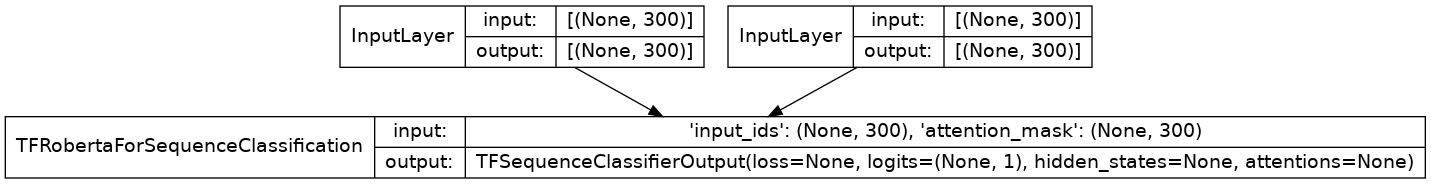

In [10]:
tf.keras.utils.plot_model(model,
    show_shapes=True, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=96)

<a id = 'train'></a>
# Training 💪

We train the model for `N_FOLDS` and save our model metrics to Weights and Biases for efficient model monitoring and tracking. Visit the [**Weights and Biases Project Page**](https://wandb.ai/sauravmaheshkar/commonlit) to see the metrics

![](https://raw.githubusercontent.com/SauravMaheshkar/CommonLit-Readibility/a5ce1a982c59f8d3dd86a4b9e4a9b5108ccdfb26/assets/Val_MSE_Ex.svg)

![](https://raw.githubusercontent.com/SauravMaheshkar/CommonLit-Readibility/a5ce1a982c59f8d3dd86a4b9e4a9b5108ccdfb26/assets/MSE_Ex.svg)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)

history_list = []
test_pred = []

for fold,(idxT, idxV) in enumerate(skf.split(train)):
        
    # Log information
    print(f'\nFOLD: {fold+1}')

    # Create Model
    tf.keras.backend.clear_session()
    with strategy.scope():
        encoder = TFAutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)
        model = get_model(encoder, SEQ_LEN)

    # Callbacks
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        patience=8, restore_best_weights=True)
    
    # Create a W&B run
    run = wandb.init(project='commonlit', entity='sauravmaheshkar', reinit=True, sync_tensorboard=True)

    # Train
    history = model.fit(x=get_dataset(train.loc[idxT], tokenizer, repeated=True, is_sampled=True, 
                                      batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        validation_data=get_dataset(train.loc[idxV], tokenizer, ordered=True, 
                                                    batch_size=BATCH_SIZE, seq_len=SEQ_LEN), 
                        steps_per_epoch=100, 
                        callbacks=[early_stopping_cb,WandbCallback(monitor='val_mse', mode='min', 
                                 save_model=False)], 
                        epochs=EPOCHS,  
                        verbose=1).history
    
    run.finish()
      
    history_list.append(history)
    
    # Test predictions
    test_ds = get_dataset(test, tokenizer, labeled=False, ordered=True, batch_size=BATCH_SIZE, seq_len=SEQ_LEN)
    x_test = test_ds.map(lambda sample: sample)
    test_pred.append(model.predict(x_test)['logits'])


FOLD: 1


wandb: Currently logged in as: sauravmaheshkar (use `wandb login --relogin` to force relogin)


Epoch 1/15
100/100 [==============================] - 33s 250ms/step - loss: 5.1451 - mse: 5.1451 - val_loss: 1.7975 - val_mse: 1.7975
Epoch 2/15
100/100 [==============================] - 23s 233ms/step - loss: 1.8362 - mse: 1.8362 - val_loss: 1.3416 - val_mse: 1.3416
Epoch 3/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6101 - mse: 1.6101 - val_loss: 3.4378 - val_mse: 3.4378
Epoch 4/15
100/100 [==============================] - 23s 233ms/step - loss: 1.8404 - mse: 1.8404 - val_loss: 1.0487 - val_mse: 1.0487
Epoch 5/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6972 - mse: 1.6972 - val_loss: 1.1934 - val_mse: 1.1934
Epoch 6/15
100/100 [==============================] - 23s 233ms/step - loss: 1.3197 - mse: 1.3197 - val_loss: 1.1482 - val_mse: 1.1482
Epoch 7/15
100/100 [==============================] - 23s 233ms/step - loss: 1.5988 - mse: 1.5988 - val_loss: 1.2254 - val_mse: 1.2254
Epoch 8/15
100/100 [==============================] - 2

epoch,14
loss,1.32249
mse,1.32249
val_loss,1.05217
val_mse,1.05217
_runtime,368
_timestamp,1620724306
_step,14
best_val_mse,1.04741
best_epoch,9


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▄▃▃▂▃▂▁▃▂▂▁▁▁
mse,█▄▄▃▃▂▃▂▁▃▂▂▁▁▁
val_loss,▃▂█▁▁▁▂▁▁▁▁▁▁▁▁
val_mse,▃▂█▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▂▂▃▃▄▄▅▅▆▆▆▇██
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█



FOLD: 2


Epoch 1/15
100/100 [==============================] - 33s 246ms/step - loss: 9.0125 - mse: 9.0125 - val_loss: 1.1582 - val_mse: 1.1582
Epoch 2/15
100/100 [==============================] - 23s 232ms/step - loss: 1.4335 - mse: 1.4335 - val_loss: 2.7910 - val_mse: 2.7910
Epoch 3/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6284 - mse: 1.6284 - val_loss: 1.3887 - val_mse: 1.3887
Epoch 4/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6524 - mse: 1.6524 - val_loss: 2.1787 - val_mse: 2.1787
Epoch 5/15
100/100 [==============================] - 23s 232ms/step - loss: 1.5752 - mse: 1.5752 - val_loss: 1.5447 - val_mse: 1.5447
Epoch 6/15
100/100 [==============================] - 23s 233ms/step - loss: 1.4165 - mse: 1.4165 - val_loss: 1.1565 - val_mse: 1.1565
Epoch 7/15
100/100 [==============================] - 23s 234ms/step - loss: 1.6704 - mse: 1.6704 - val_loss: 1.7520 - val_mse: 1.7520
Epoch 8/15
100/100 [==============================] - 2

epoch,13
loss,1.33135
mse,1.33135
val_loss,1.34519
val_mse,1.34519
_runtime,343
_timestamp,1620724659
_step,13
best_val_mse,1.15649
best_epoch,5


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▂▂▁▁▂▁▁▂▁▁▁▁
mse,█▂▂▂▁▁▂▁▁▂▁▁▁▁
val_loss,▁█▂▅▃▁▄▁▁▁▁▂▁▂
val_mse,▁█▂▅▃▁▄▁▁▁▁▂▁▂
_runtime,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█



FOLD: 3


Epoch 1/15
100/100 [==============================] - 33s 247ms/step - loss: 7.9385 - mse: 7.9385 - val_loss: 1.6586 - val_mse: 1.6586
Epoch 2/15
100/100 [==============================] - 23s 232ms/step - loss: 2.1340 - mse: 2.1340 - val_loss: 1.0567 - val_mse: 1.0567
Epoch 3/15
100/100 [==============================] - 23s 233ms/step - loss: 1.8644 - mse: 1.8644 - val_loss: 1.9626 - val_mse: 1.9626
Epoch 4/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6183 - mse: 1.6183 - val_loss: 1.1096 - val_mse: 1.1096
Epoch 5/15
100/100 [==============================] - 23s 232ms/step - loss: 1.4974 - mse: 1.4974 - val_loss: 1.1991 - val_mse: 1.1991
Epoch 6/15
100/100 [==============================] - 23s 232ms/step - loss: 1.4041 - mse: 1.4041 - val_loss: 1.0813 - val_mse: 1.0813
Epoch 7/15
100/100 [==============================] - 23s 232ms/step - loss: 1.5308 - mse: 1.5308 - val_loss: 2.6805 - val_mse: 2.6805
Epoch 8/15
100/100 [==============================] - 2

epoch,14
loss,1.46105
mse,1.46105
val_loss,1.05648
val_mse,1.05648
_runtime,367
_timestamp,1620725035
_step,14
best_val_mse,1.05008
best_epoch,12


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▄▃▂▂▁▂▁▁▁▁▂▁▁▁
mse,█▄▃▂▂▁▂▁▁▁▁▂▁▁▁
val_loss,▄▁▅▁▂▁█▁▁▁▂▁▁▁▁
val_mse,▄▁▅▁▂▁█▁▁▁▂▁▁▁▁
_runtime,▁▁▂▂▃▃▄▄▅▆▆▆▇██
_timestamp,▁▁▂▂▃▃▄▄▅▆▆▆▇██
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█



FOLD: 4


Epoch 1/15
100/100 [==============================] - 32s 246ms/step - loss: 7.4074 - mse: 7.4074 - val_loss: 1.1080 - val_mse: 1.1080
Epoch 2/15
100/100 [==============================] - 23s 232ms/step - loss: 1.5743 - mse: 1.5743 - val_loss: 1.3274 - val_mse: 1.3274
Epoch 3/15
100/100 [==============================] - 23s 231ms/step - loss: 1.6899 - mse: 1.6899 - val_loss: 1.1467 - val_mse: 1.1467
Epoch 4/15
100/100 [==============================] - 23s 232ms/step - loss: 2.0837 - mse: 2.0837 - val_loss: 1.2669 - val_mse: 1.2669
Epoch 5/15
100/100 [==============================] - 23s 233ms/step - loss: 1.6921 - mse: 1.6921 - val_loss: 1.0836 - val_mse: 1.0836
Epoch 6/15
100/100 [==============================] - 23s 232ms/step - loss: 1.4863 - mse: 1.4863 - val_loss: 1.5202 - val_mse: 1.5202
Epoch 7/15
100/100 [==============================] - 23s 232ms/step - loss: 1.8344 - mse: 1.8344 - val_loss: 2.4153 - val_mse: 2.4153
Epoch 8/15
100/100 [==============================] - 2

epoch,12
loss,1.46516
mse,1.46516
val_loss,1.1316
val_mse,1.1316
_runtime,320
_timestamp,1620725365
_step,12
best_val_mse,1.08361
best_epoch,4


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss,█▂▂▃▂▂▂▂▂▂▁▂▂
mse,█▂▂▃▂▂▂▂▂▂▁▂▂
val_loss,▁▂▁▂▁▃█▃▅▁▁▁▁
val_mse,▁▂▁▂▁▃█▃▅▁▁▁▁
_runtime,▁▂▂▃▃▄▄▅▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▆▆▇▇█
_step,▁▂▂▃▃▄▅▅▆▆▇▇█



FOLD: 5


Epoch 1/15
100/100 [==============================] - 33s 253ms/step - loss: 12.2736 - mse: 12.2736 - val_loss: 1.2276 - val_mse: 1.2276
Epoch 2/15
100/100 [==============================] - 23s 234ms/step - loss: 1.4733 - mse: 1.4733 - val_loss: 1.2707 - val_mse: 1.2707
Epoch 3/15
100/100 [==============================] - 23s 234ms/step - loss: 1.4297 - mse: 1.4297 - val_loss: 2.2829 - val_mse: 2.2829
Epoch 4/15
100/100 [==============================] - 23s 232ms/step - loss: 1.6462 - mse: 1.6462 - val_loss: 1.6083 - val_mse: 1.6083
Epoch 5/15
100/100 [==============================] - 23s 233ms/step - loss: 1.7034 - mse: 1.7034 - val_loss: 1.7289 - val_mse: 1.7289
Epoch 6/15
100/100 [==============================] - 23s 232ms/step - loss: 1.4607 - mse: 1.4607 - val_loss: 1.2139 - val_mse: 1.2139
Epoch 7/15
100/100 [==============================] - 23s 231ms/step - loss: 1.8960 - mse: 1.8960 - val_loss: 1.0724 - val_mse: 1.0724
Epoch 8/15
100/100 [==============================] -

epoch,14
loss,1.38011
mse,1.38011
val_loss,1.01074
val_mse,1.01074
_runtime,370
_timestamp,1620725744
_step,14
best_val_mse,1.01074
best_epoch,14


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▂▁▂▂▁▁▂▁▁▁▁▁
mse,█▁▁▂▁▂▂▁▁▂▁▁▁▁▁
val_loss,▂▂█▄▅▂▁▂▃▁▁▂▁▁▁
val_mse,▂▂█▄▅▂▁▂▃▁▁▂▁▁▁
_runtime,▁▂▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▂▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


# Submission

In [12]:
submission = test[['id']]
submission['target'] = np.mean(test_pred, axis=0)
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,id,target
0,c0f722661,-0.958566
1,f0953f0a5,-0.958566
2,0df072751,-0.958566
3,04caf4e0c,-0.958566
4,0e63f8bea,-0.958566
5,12537fe78,-0.958566
6,965e592c0,-0.958566
